In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import celltypist

sc.settings.n_jobs = 8
sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=100, facecolor='white', figsize=(5,5), frameon=False)

In [4]:
adata_h = sc.read_h5ad('../data/BF_neuron.h5ad')

In [5]:
adata_m = sc.read_h5ad('./Results_h5ad/03_scRNA_10x_AIBA_subsample.h5ad')

In [6]:
# remove non-neuronal cells
adata_m = adata_m[~adata_m.obs['class'].isin(['Astro-Epen','Immune','OPC-Oligo','Vascular'])].copy()

In [7]:
adata_h.X = adata_h.layers['counts'].copy()

In [8]:
from mousipy import translate, check_orthologs

adata_h = translate(adata_h)

100%|██████████| 27175/27175 [00:45<00:00, 601.82it/s]


Found direct orthologs for 14676 genes.
Found multiple orthologs for 448 genes.
Found no orthologs for 4784 genes.
Found no index in biomart for 7267 genes.


100%|██████████| 448/448 [05:26<00:00,  1.37it/s]


In [9]:
adata_m.obs['species'] = 'mouse'
adata_h.obs['species'] = 'human'

In [10]:
intersect_genes = adata_m.var_names.intersection(adata_h.var_names)

In [11]:
adata_m = adata_m[:,intersect_genes].copy()
adata_h = adata_h[:,intersect_genes].copy()

In [12]:
adata_m.X = adata_m.layers['counts'].copy()

In [13]:
for adata in [adata_m, adata_h]:
    adata.layers['counts'] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.layers['log_norm'] = adata.X.copy()

# Clustering of human data

In [14]:
adata_h_ls = adata_h[(adata_h[:,['Prdm16']].X > 0)].copy()

In [15]:
sc.pp.regress_out(adata_h_ls, ['total_UMIs'])
sc.pp.scale(adata_h_ls, max_value=10)
sc.tl.pca(adata_h_ls)
sc.pp.neighbors(adata_h_ls, n_neighbors=50)
sc.tl.umap(adata_h_ls)
sc.tl.leiden(adata_h_ls, resolution=0.4)

... storing 'species' as categorical
... storing 'Gene_ID' as categorical
... storing 'original_gene_symbol' as categorical


In [16]:
sc.tl.leiden(adata_h_ls, resolution=0.4)

# Label transfer with celltypist

In [17]:
# subset to cells with LSX identity
adata_m = adata_m[adata_m.obs['class'].str.startswith('LSX')].copy()

In [18]:
model_fs = celltypist.train(adata_m, 'class', n_jobs = 10, max_iter = 100, use_SGD = True)

🍳 Preparing data before training
✂️ 303 non-expressed genes are filtered out
🔬 Input data has 27424 cells and 15297 genes
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
✅ Model training done!


In [19]:
gene_index = np.argpartition(np.abs(model_fs.classifier.coef_), -100, axis = 1)[:, -300:]
gene_index = np.unique(gene_index)

In [20]:
print(f"Number of genes selected: {len(gene_index)}")

Number of genes selected: 1198


In [26]:
model = celltypist.train(adata_m[:, gene_index], 'class', check_expression = False, n_jobs = 10, max_iter = 300)

🍳 Preparing data before training
✂️ 8 non-expressed genes are filtered out
🔬 Input data has 27424 cells and 1143 genes
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!


In [27]:
model.write('./celltypist_model/model_cross_species.pkl')

In [27]:
adata_h_ls.X = adata_h_ls.layers['log_norm'].copy()

In [28]:
predictions = celltypist.annotate(adata_h_ls, model='./celltypist_model/model_cross_species.pkl', majority_voting=True)

🔬 Input data has 1639 cells and 15600 genes
🔗 Matching reference genes in the model
🧬 1143 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


In [29]:
adata_h_ls.obs[['predicted_labels','majority_voting']] = predictions.predicted_labels[['predicted_labels','majority_voting']]

In [26]:
adata_m_lsx = adata_m[adata_m.obs['class'].str.startswith('LSX')].copy()

In [31]:
sc.tl.umap(adata_m_lsx)

In [32]:
color_map = {'Astro-Epen': '#ffff00',
 'CB GABA': '#1ce6ff',
 'CB Glut': '#ff34ff',
 'CNU-HYa GABA': '#ff4a46',
 'CNU-HYa Glut': '#008941',
 'CNU-LGE GABA': '#006fa6',
 'CNU-MGE GABA': '#a30059',
 'CTX-CGE GABA': '#ffdbe5',
 'CTX-MGE GABA': '#7a4900',
 'DG-IMN Glut': '#0000a6',
 'HY GABA': '#63ffac',
 'HY Glut': '#b79762',
 'HY Gnrh1 Glut': '#004d43',
 'HY MM Glut': '#8fb0ff',
 'IT-ET Glut': '#997d87',
 'Immune': '#5a0007',
 'LSX Nkx2-1 Gaba': '#809693',
 'LSX Otx2 Gaba': '#6a3a4c',
 'LSX Prdm12 Slit2 Gaba': '#1b4400',
 'LSX Prdm12 Zeb2 Gaba': '#4fc601',
 'LSX Sall3 Lmo1 Gaba': '#3b5dff',
 'LSX Sall3 Pax6 Gaba': '#4a3b53',
 'MB Dopa': '#ff2f80',
 'MB GABA': '#61615a',
 'MB Glut': '#ba0900',
 'MB-HB Sero': '#6b7900',
 'MH-LH Glut': '#00c2a0',
 'MY GABA': '#ffaa92',
 'MY Glut': '#ff90c9',
 'NP-CT-L6b Glut': '#b903aa',
 'OB-CR Glut': '#d16100',
 'OB-IMN GABA': '#ddefff',
 'OEC': '#000035',
 'OPC-Oligo': '#7b4f4b',
 'P GABA': '#a1c299',
 'P Glut': '#300018',
 'Pineal Glut': '#0aa6d8',
 'TH Glut': '#013349',
 'Vascular': '#00846f',
 'N.A.': '#f4fafc'}

... storing 'species' as categorical


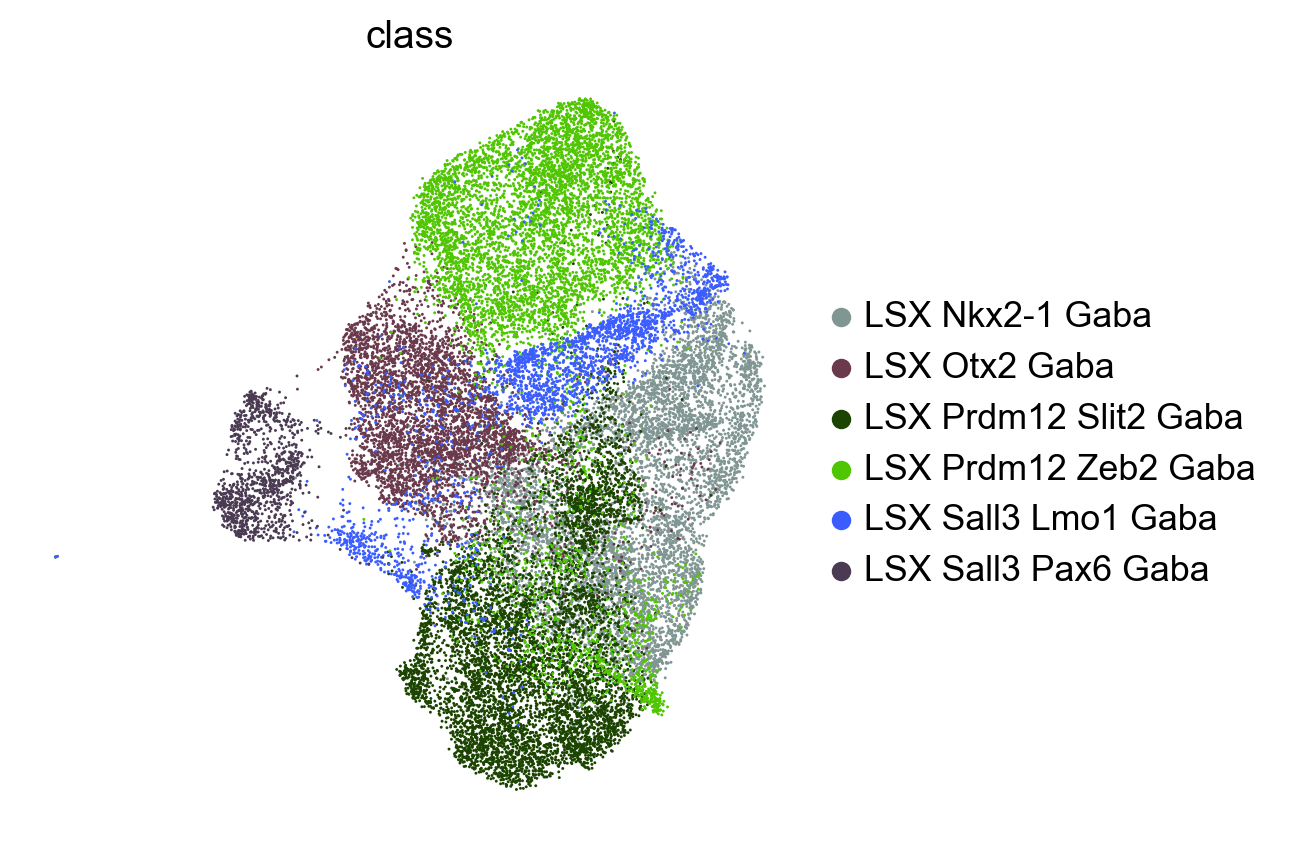

In [33]:
sc.pl.umap(adata_m_lsx, color=['class'], layer='log2', palette=color_map)

In [31]:
# adata_h_ls.obsm['X_umap'] = adata_h_ls.obsm['X_UMAP'].copy()

In [43]:
lsx_grp = adata_h_ls.obs.predicted_labels[adata_h_ls.obs.predicted_labels.str.startswith('LSX')].unique()

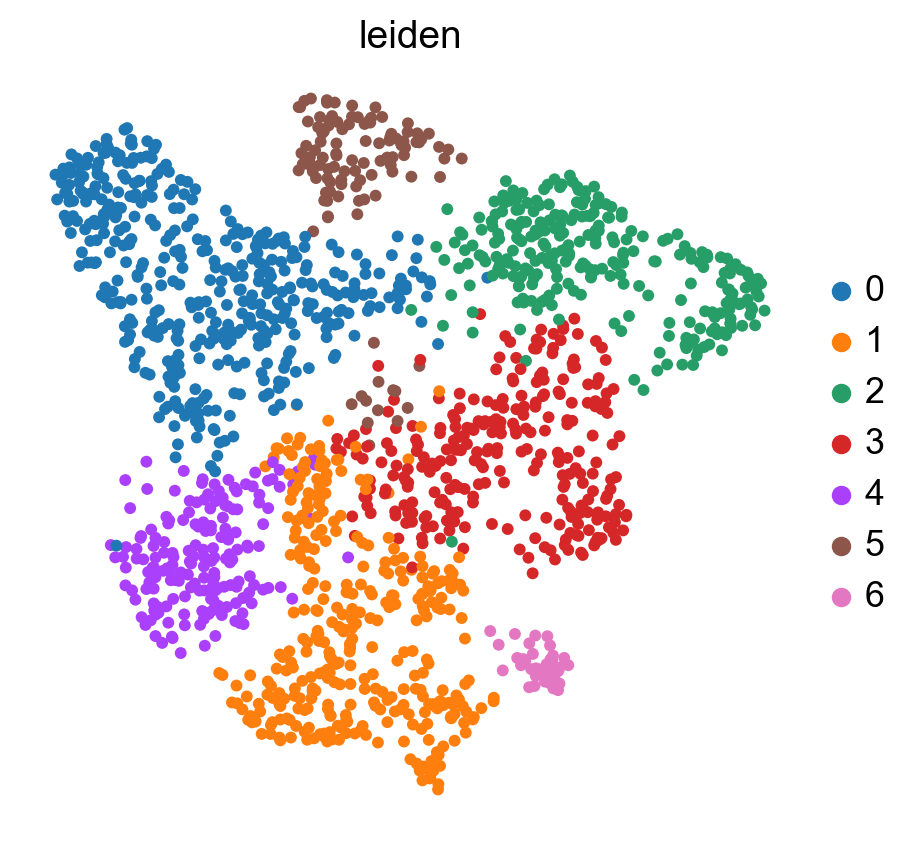

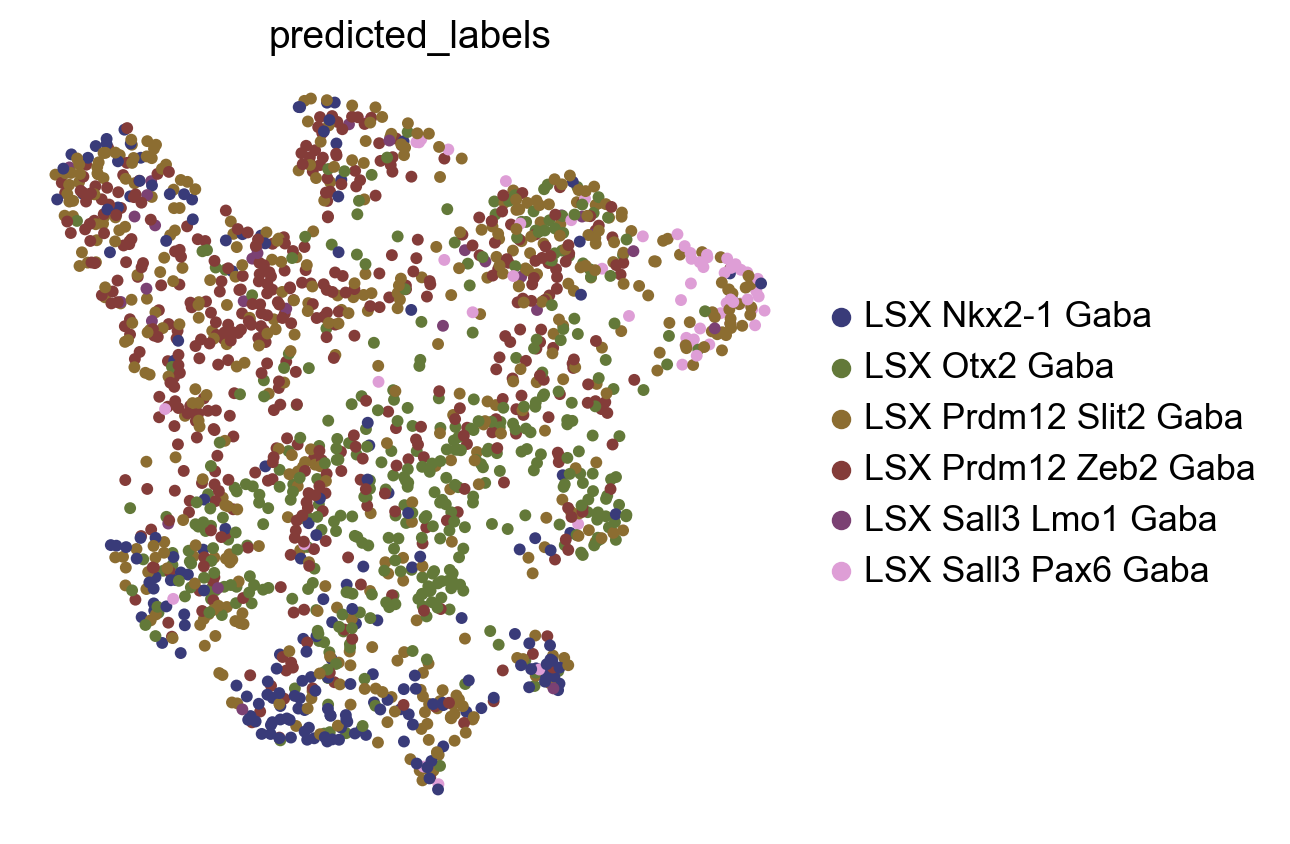

In [34]:
sc.pl.umap(adata_h_ls, color=['leiden'])
sc.pl.umap(adata_h_ls, color=['predicted_labels'], palette='tab20b')

In [21]:
adata_h_ls = adata_h_ls[adata_h_ls.obs.supercluster_term == 'Splatter'].copy()

In [22]:
adata_h_ls = adata_h_ls[adata_h_ls[:,'Prdm12'].X > 0]

In [41]:
sc.pp.scale(adata_h_ls, max_value=10)
sc.tl.pca(adata_h_ls)
sc.pp.neighbors(adata_h_ls, n_neighbors=50)
sc.tl.umap(adata_h_ls)
sc.tl.leiden(adata_h_ls, resolution=0.4)

In [46]:
sc.tl.leiden(adata_h_ls, resolution=0.5)

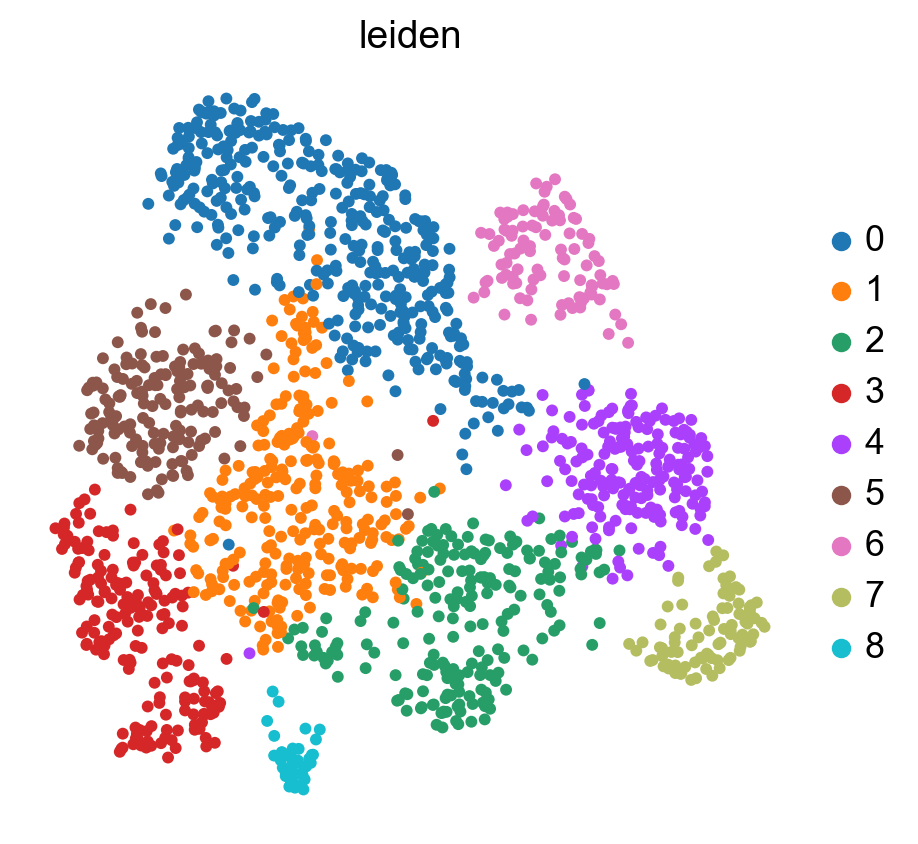

In [47]:
sc.pl.umap(adata_h_ls, color=['leiden'], na_in_legend=False)

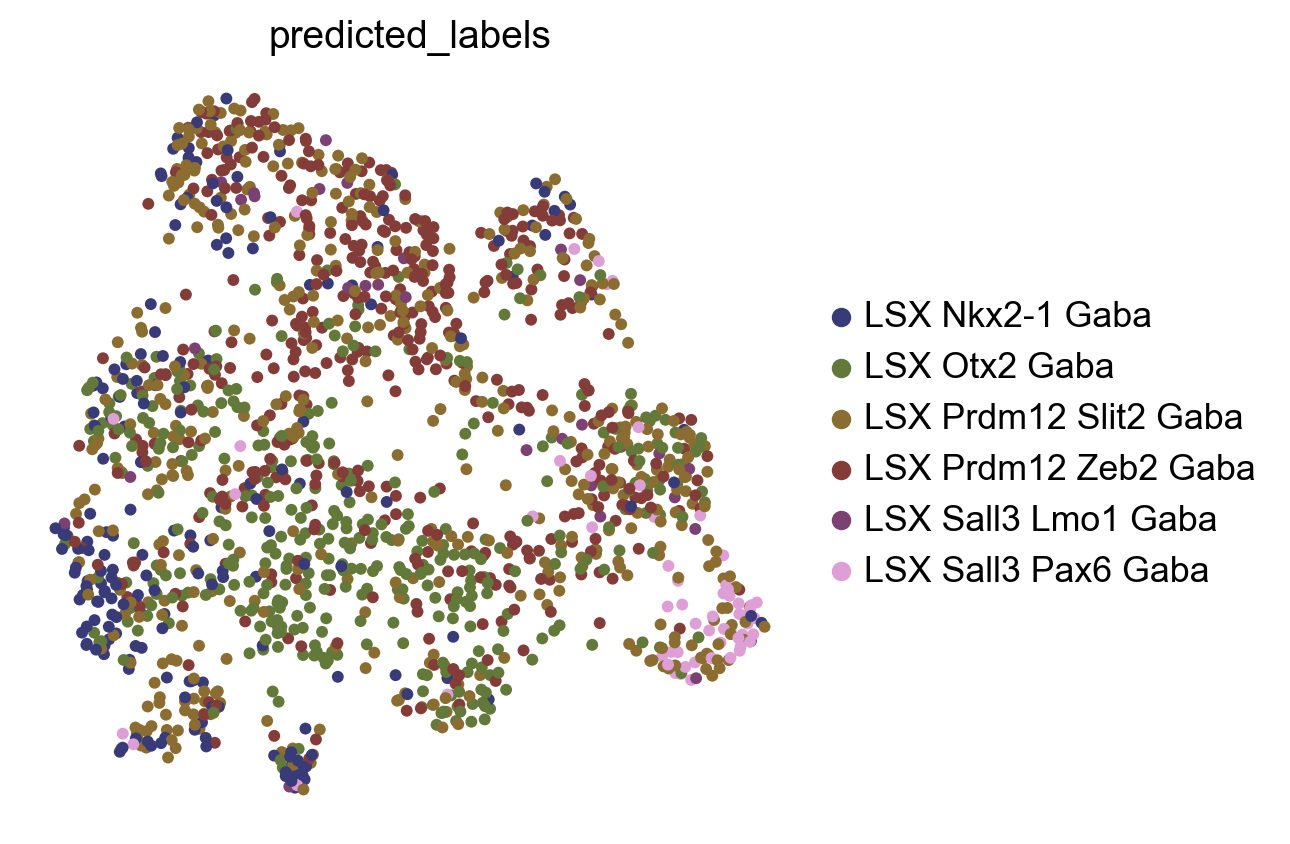

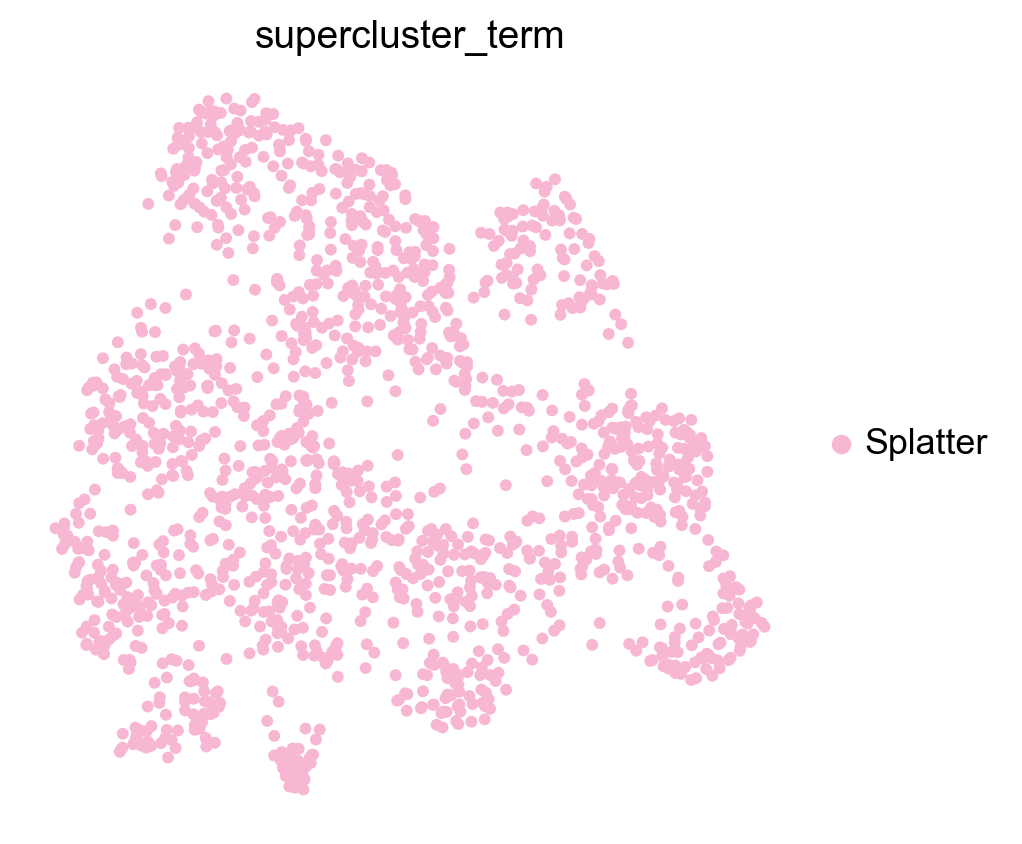

In [45]:
sc.pl.umap(adata_h_ls, color=['predicted_labels'], groups=lsx_grp, na_in_legend=False)
sc.pl.umap(adata_h_ls, color=['supercluster_term'], na_in_legend=False)

In [48]:
adata_h_ls = adata_h_ls[adata_h_ls.obs.leiden != '8'].copy()

In [49]:
adata_h_ls.obsm['X_umap'] = adata_h_ls.obsm['X_UMAP'].copy()

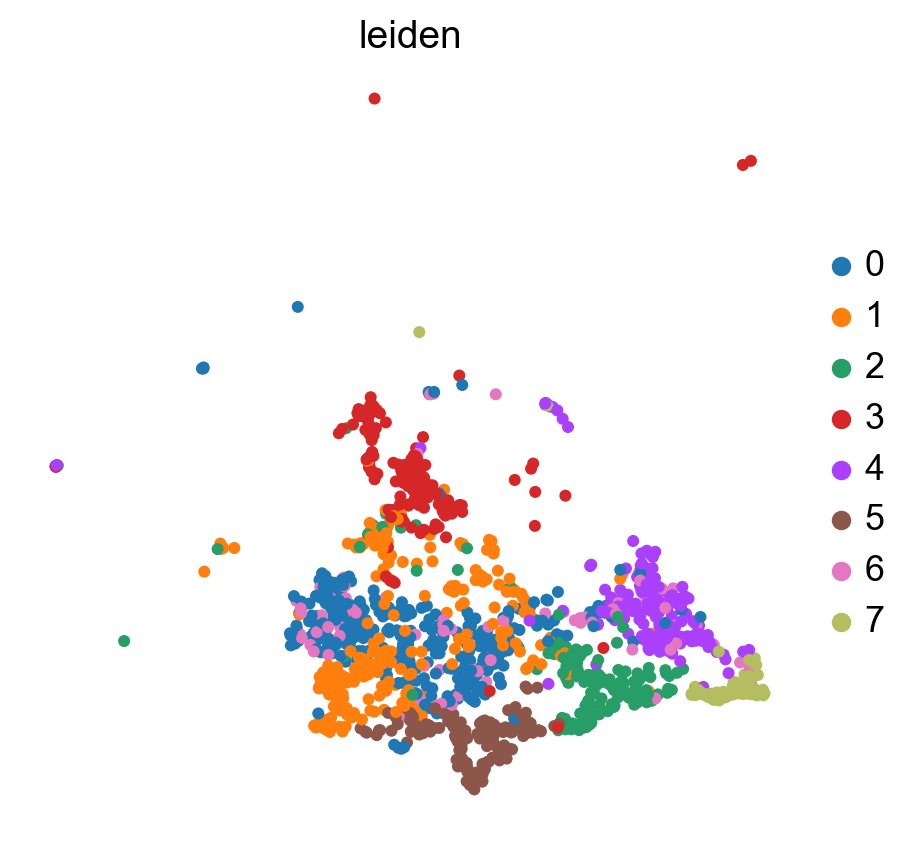

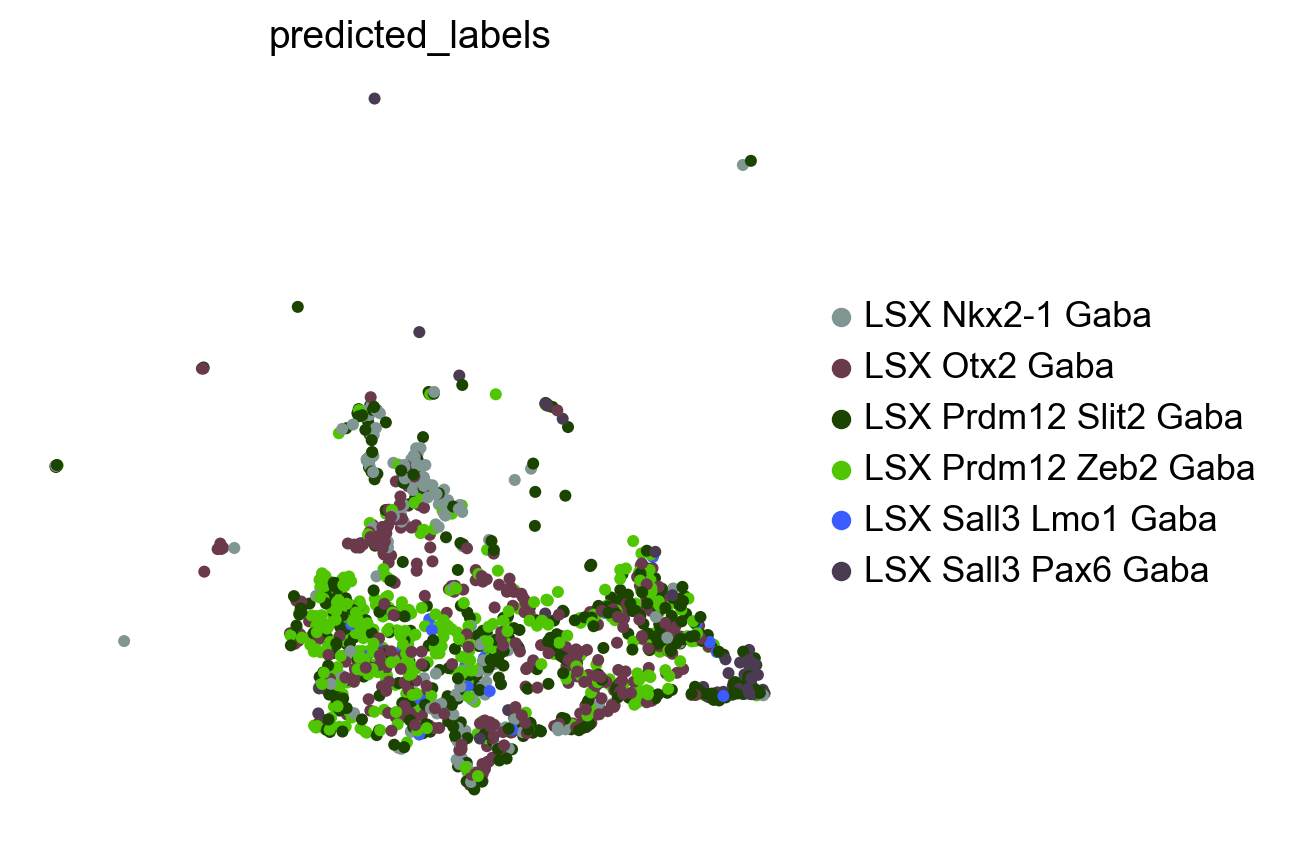

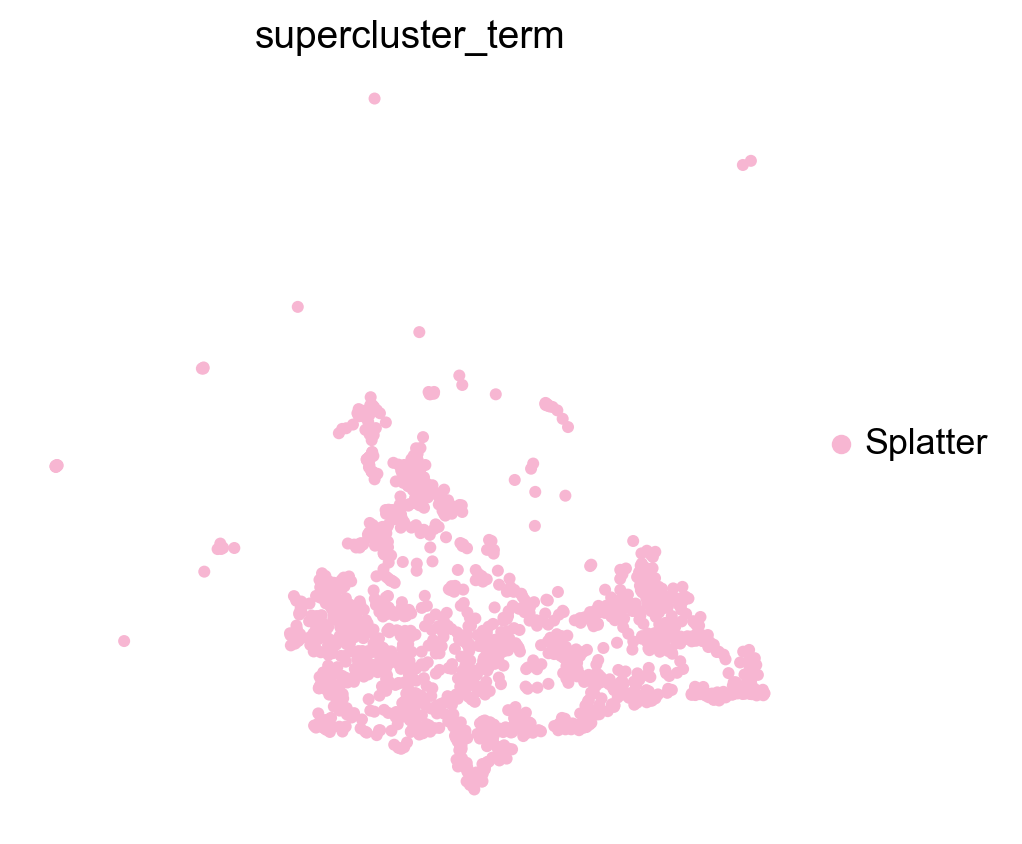

In [50]:
sc.pl.umap(adata_h_ls, color=['leiden'], na_in_legend=False)
sc.pl.umap(adata_h_ls, color=['predicted_labels'], groups=lsx_grp, na_in_legend=False, palette=color_map)
sc.pl.umap(adata_h_ls, color=['supercluster_term'], na_in_legend=False)

In [81]:
# read the marker table from scRNA-seq
class_mk = pd.read_excel('./Results_table/05_scRNA_10x_AIBA_class_mk.xlsx', index_col=0)

In [82]:
class_mk = class_mk[class_mk.group.str.startswith('LSX')].copy()

In [104]:
class_mk = class_mk[class_mk.names.isin(adata_h_ls.var_names)].reset_index(drop=True)

In [159]:
class_mk = class_mk[~class_mk.names.duplicated(False)]

In [160]:
top30_mk = class_mk.groupby('group').head(100)

In [162]:
top30_mk.reset_index(inplace=True, drop=True)

In [163]:
top30_mk.index = top30_mk.names

In [164]:
ser_counts = adata_h_ls.obs["leiden"].value_counts()
ser_counts.name = "cell counts"
meta_leiden = pd.DataFrame(ser_counts)

cat_name = "leiden"
sig_leiden = pd.DataFrame(
    columns=adata_h_ls.var_names, index=adata_h_ls.obs[cat_name].cat.categories
)
for clust in adata_h_ls.obs[cat_name].cat.categories:
    sig_leiden.loc[clust] = adata_h_ls[adata_h_ls.obs[cat_name].isin([clust]), :].layers['log_norm'].mean(0)
    
sig_leiden = sig_leiden.transpose()
# leiden_clusters = ["Leiden-" + str(x) for x in sig_leiden.columns.tolist()]
sig_leiden.columns = sig_leiden.columns.tolist()
meta_leiden.index = sig_leiden.columns.tolist()
meta_leiden[cat_name] = pd.Series(
    meta_leiden.index.tolist(), index=meta_leiden.index.tolist()
)

In [165]:
meta_gene = pd.DataFrame(index=top30_mk.names.tolist())
meta_gene["info"] = ""
meta_gene["Markers"] = top30_mk["group"]

In [203]:
meta_leiden["Cell_Type"] = 'N.A.'
for inst_cluster in sig_leiden.columns.tolist():
    top_genes = (
        sig_leiden[inst_cluster]
        .sort_values(ascending=False)
        .index.tolist()[:3500]
    )
    inst_ser = meta_gene.loc[meta_gene.index.isin(top_genes), "Markers"]
    inst_ser = inst_ser[inst_ser != "N.A."]
    ser_counts = inst_ser.value_counts()
    max_count = ser_counts.max()

    max_cat = "_".join(sorted(ser_counts[ser_counts == max_count].index.tolist()))
    max_cat = max_cat.replace(" marker", "")

    print(inst_cluster, max_cat)
    meta_leiden.loc[inst_cluster, "Cell_Type"] = max_cat

0 LSX Prdm12 Zeb2 Gaba
1 LSX Otx2 Gaba
2 LSX Sall3 Pax6 Gaba
3 LSX Prdm12 Slit2 Gaba
4 LSX Prdm12 Slit2 Gaba
5 LSX Otx2 Gaba
6 LSX Prdm12 Zeb2 Gaba
7 LSX Sall3 Pax6 Gaba


In [204]:
adata_h_ls.obs['cluster_pred'] = adata_h_ls.obs.leiden.map(meta_leiden.Cell_Type.to_dict())

In [205]:
# group_df = adata_h_ls.obs.groupby('leiden').predicted_labels.value_counts().to_frame()
# group_df = group_df.reset_index()
# group_df.rename(columns={'leiden':'source','predicted_labels':'target'}, inplace=True)

In [232]:
group_df = adata_h_ls.obs.groupby('leiden').cluster_pred.value_counts().to_frame()
group_df = group_df.reset_index()
group_df.rename(columns={'leiden':'source','cluster_pred':'target'}, inplace=True)

In [233]:
group_df = group_df[group_df['count'] > 0].reset_index(drop=True)
group_df

,source,target,count
0,0,LSX Prdm12 Zeb2 Gaba,387
1,1,LSX Otx2 Gaba,272
2,2,LSX Sall3 Pax6 Gaba,208
3,3,LSX Prdm12 Slit2 Gaba,192
4,4,LSX Prdm12 Slit2 Gaba,192
5,5,LSX Otx2 Gaba,166
6,6,LSX Prdm12 Zeb2 Gaba,97
7,7,LSX Sall3 Pax6 Gaba,88


In [234]:
group_df.target = group_df.target.str.replace('Prdm12 ','')

In [132]:
group_df.to_csv('./Results_table/07_cross_species_human.csv', index=False)

In [184]:
import plotly.graph_objects as go
import numpy as np

In [2]:
group_df = pd.read_csv('./Results_table/07_cross_species_human.csv')

In [235]:
categories = ['source', 'target']
newDf = pd.DataFrame()
for i in range(len(categories)-1):
    tempDf = group_df[[categories[i],categories[i+1],'count']]
    tempDf.columns = ['source','target','count']
    newDf = pd.concat([newDf,tempDf])    
newDf = newDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()

label_list = list(np.unique(group_df[categories].values))
source = newDf['source'].apply(lambda x: label_list.index(x))
target = newDf['target'].apply(lambda x: label_list.index(x))
count = newDf['count']

In [236]:
import plotly.express as px
import matplotlib.colors

In [237]:
sk_color = {'LSX Nkx2-1 Gaba': '#809693',
 'LSX Otx2 Gaba': '#6a3a4c',
 'LSX Slit2 Gaba': '#1b4400',
 'LSX Zeb2 Gaba': '#4fc601',
 'LSX Sall3 Lmo1 Gaba': '#3b5dff',
 'LSX Sall3 Pax6 Gaba': '#4a3b53',
 '0': '#1f77b4',
 '1': '#ff7f0e',
 '2': '#279e68',
 '3': '#d62728',
 '4': '#aa40fc',
 '5': '#8c564b',
 '6': '#e377c2',
 '7': '#b5bd61'
 }

In [240]:
fig = go.Figure(data=[go.Sankey(
    node = {"label": label_list, 'color':[sk_color[x] for x in label_list]},
    link = {"source": source, "target": target, "value": count, 'color':newDf['source'].map(sk_color).to_list()}
    )])
fig.update_layout(height=800)
fig.show()

In [248]:
fig = go.Figure(data=[go.Sankey(
    node = {"label": label_list, 'color':[sk_color[x] for x in label_list]},
    link = {"source": source, "target": target, "value": count, 'color':newDf['source'].map(sk_color).to_list()}
    )])
fig.update_layout(height=800)
fig.show()

In [243]:
adata_h_ls.obs.cluster_pred = adata_h_ls.obs.cluster_pred.str.replace('Prdm12 ','')

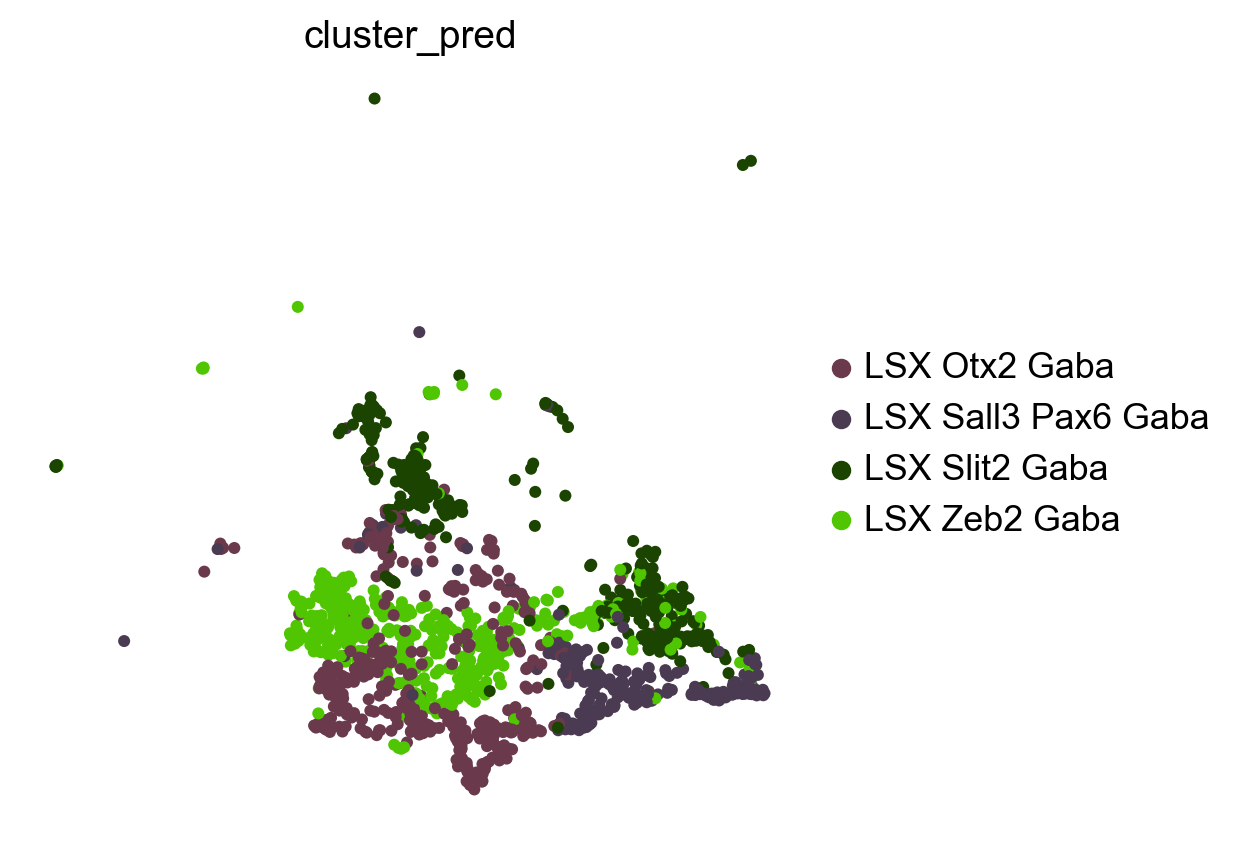

In [245]:
sc.pl.umap(adata_h_ls, color=['cluster_pred'], na_in_legend=False, palette=sk_color)

In [246]:
adata_m_lsx.obs['class_lsx'] = adata_m_lsx.obs['class'].str.replace('Prdm12 ','')

... storing 'class_lsx' as categorical


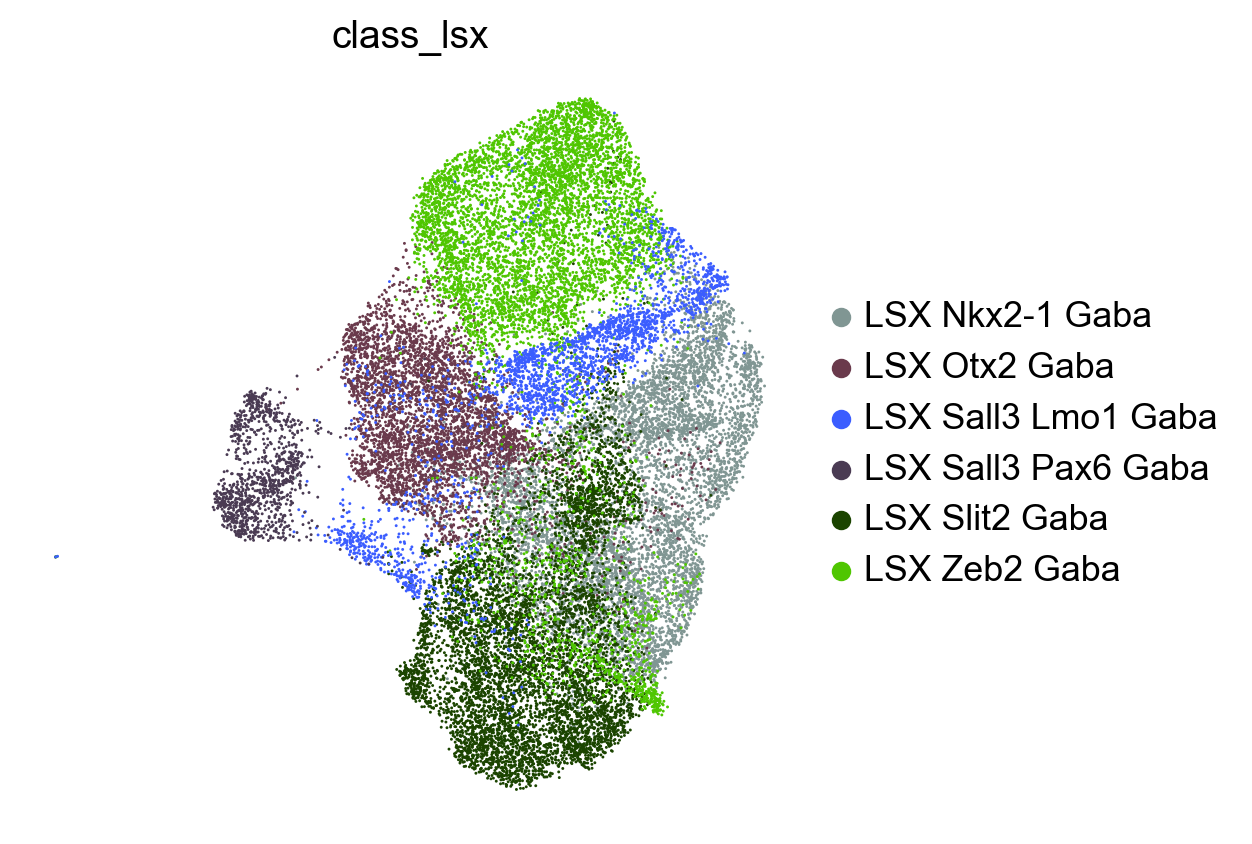

In [247]:
sc.pl.umap(adata_m_lsx, color=['class_lsx'], layer='log2', palette=sk_color)